## Data

The code block below downloads the Flickr8k image dataset and corresponding captions. Alternatively, you may choose to manually download the data:

> 1. [Flickr8k_Dataset.zip](https://github.com/jbrownlee/Datasets/releases/tag/Flickr8k)
> 2. [Flickr8k_train.token.txt and Flickr8k_test.token.txt](https://github.com/ysbecca/flickr8k-custom/tree/main/captions)

In [1]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -qq
!unzip Flickr8k_Dataset.zip   
!git clone https://github.com/ysbecca/flickr8k-custom -qq

Archive:  Flickr8k_Dataset.zip
   creating: Flicker8k_Dataset/
  inflating: Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: __MACOSX/
   creating: __MACOSX/Flicker8k_Dataset/
  inflating: __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: Flicker8k_Dataset/1002674143_1b742ab4b8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1002674143_1b742ab4b8.jpg  
  inflating: Flicker8k_Dataset/1003163366_44323f5815.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1003163366_44323f5815.jpg  
  inflating: Flicker8k_Dataset/1007129816_e794419615.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1007129816_e794419615.jpg  
  inflating: Flicker8k_Dataset/1007320043_627395c3d8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1007320043_627395c3d8.jpg  
  inflating: Flicker8k_Dataset/1009434119_febe49276a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/

In [2]:
!pip install gdown -qq
!gdown --id 1kZWbTPfM7g22wPwzOFuybH02_n2Ljnb1

Downloading...
From: https://drive.google.com/uc?id=1kZWbTPfM7g22wPwzOFuybH02_n2Ljnb1
To: /kaggle/working/features.pt
100%|█████████████████████████████████████████| 290M/290M [00:01<00:00, 187MB/s]


## Imports

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import re
from torch.utils.data import Dataset,DataLoader
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import nltk


## Part 1

The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use an RNN). 

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.



The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks. 

We will first extract the feature representations of the images from the Encoder and save them. During training of the Decoder, we only need to iterate over the image feature data and the reference captions.

### **Overview:**
*   **1.1** Text preparation
*   **1.2** Extracting image features
*   **1.3** Training DecoderRNN


## 1.1 Text preparation 


### 1.1.1 Cleaning the reference captions 

Open the token file ```Flickr8k_train.token.txt``` to see the reference caption format. Remember that there are 5 reference captions per unique image.

Reading the token file line by line, and parse each line. Save two lists:

> 1. A list of the image IDs (each repeated 5 times as appears in the token file); i.e., ```["1000268201_693b08cb0e.jpg", "1000268201_693b08cb0e.jpg", ...]```
> 2. A list of lists of words in each caption; i.e., ```[["a", "child", "in", "a", "pink"...], ["a", "girl", "going", ...], ...]```.

For each caption, before converting to the list of lists of words (2), first:

> 1. Cleaning text by removing any punctuation (periods, commas, etc.), numbers, and symbols.
> 2. Converting all remaining words into lowercase.


In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[0-9 #+_]')

def clean_text(text):
    text=str(text)
    text=re.sub(r"\d", "", text) 
    # lowercase text
    text = REPLACE_BY_SPACE_RE.sub('', text) 
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = text.lower()
    
    return text

In [5]:
def get_ids_words(path):
  df=pd.read_csv(path,header=None,sep='\n',)
  df[['ids', 'words']] = df[0].str.split('\t', 1, expand=True)

  df['ids']=df['ids'].str[:-2]

  df["words"] = df['words'].str.replace('[^\w\s]','')
  df['words']=df["words"].apply(clean_text)
  df['words']=df["words"].str.split(' ')
  
  return df['ids'],df['words']


In [6]:
train_token_path='./flickr8k-custom/captions/Flickr8k_train.token.txt'
test_token_path='./flickr8k-custom/captions/Flickr8k_test.token.txt'

In [7]:
image_ids,captions=get_ids_words(train_token_path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [8]:
print(image_ids)
print(captions)

0        1000268201_693b08cb0e.jpg
1        1000268201_693b08cb0e.jpg
2        1000268201_693b08cb0e.jpg
3        1000268201_693b08cb0e.jpg
4        1000268201_693b08cb0e.jpg
                   ...            
35440     377872472_35805fc143.jpg
35441     377872472_35805fc143.jpg
35442     377872472_35805fc143.jpg
35443     377872472_35805fc143.jpg
35444     377872472_35805fc143.jpg
Name: ids, Length: 35445, dtype: object
0        [a, child, in, a, pink, dress, is, climbing, u...
1            [a, girl, going, into, a, wooden, building, ]
2        [a, little, girl, climbing, into, a, wooden, p...
3        [a, little, girl, climbing, the, stairs, to, h...
4        [a, little, girl, in, a, pink, dress, going, i...
                               ...                        
35440    [one, dog, is, standing, whilst, two, other, d...
35441    [three, dogs, are, playing, around, in, the, s...
35442    [three, dogs, chasing, each, other, in, the, s...
35443                      [three, dogs, pla

### 1.1.2 Building the vocabulary 

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [9]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with only the <unk> token
        self.word2idx = {'<unk>': 0}
        self.idx2word = {0: '<unk>'}
        self.idx = 1

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collecting words from the cleaned captions (1.1.1), ignoring any words which appear 3 times or less. As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary. 

In [10]:
vocab=Vocabulary()

In [11]:
from collections import Counter
words=Counter(x for xs in captions for x in set(xs))

In [12]:
for key in words:
  if words[key]>3:
    if key != '':
      vocab.add_word(key)

In [13]:
len(vocab)

3207

## 1.2 Extracting image features

### 1.2.1 EncoderCNN


In [14]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # keep all layers of the pretrained net except the last one
        self.model=nn.Sequential(*list(resnet.children())[:-1])
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        x=self.model(images)
        x=x.reshape(x.shape[0],-1)
        return x


### 1.2.2 Dataset and DataLoader

Creating PyTorch ```Dataset``` and ```DataLoader``` classes for the encoding step. Note that the encoding step only requires the **image data** to produce features, whereas the decoding step requires the **image features and reference captions** as inputs. First we create the ```Dataset``` for the encoding step. 

In [15]:
class Flickr8k_Images(Dataset):
    """ Flickr8k custom dataset to read image data only.
    """
    def __init__(self, image_ids, transform=None):
        # TO COMPLET
        self.ids=image_ids
        self.transform=transform
      
    def __len__(self):
      return len(self.ids)
        
    def __getitem__(self, index):
        # TO COMPLETE
        # returns image with transform applied

        img=Image.open(self.ids[index]).convert("RGB")

        if self.transform is not None:
          img = self.transform(img)
        return img


In [16]:
def read_paths(data_path,img_names):
  paths=[]
  for img in img_names:
    paths.append(os.path.join(data_path,img))
  return paths

In [17]:
img_paths=read_paths('./Flicker8k_Dataset',image_ids)

In [18]:
trans=transforms.Compose({
    transforms.Resize(64),
    transforms.ToTensor()
})

In [19]:
dataset=Flickr8k_Images(img_paths,transform=trans)
loader=DataLoader(dataset,batch_size=1)

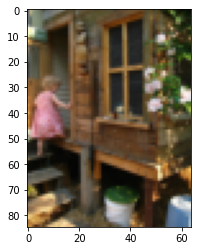

In [20]:
x=next(iter(loader))
plt.imshow(x[0].permute(1,2,0))
plt.show()

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
model_CNN=EncoderCNN().to(device=device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [23]:
features=torch.tensor([])
model_CNN.eval() 
with torch.no_grad():
    for batch_idx, (data) in enumerate(tqdm(loader)):
        
        data = data.to(device)
        output = model_CNN(data)
        
        features=torch.cat((features.to(device=device),output),dim=0)

100%|██████████| 35445/35445 [25:02<00:00, 23.59it/s]


In [24]:
torch.save(features, 'features.pt')

In [25]:
features=torch.load('./features.pt',map_location=device)

## 1.3 Training DecoderRNN 

### 1.3.1 The RNN layer 



In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        
        self.embed = nn.Embedding(vocab_size, embed_size)

        
        self.rnn = nn.RNN(embed_size,hidden_size,num_layers,batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        
        im_features = self.resize(features)
        
        
        im_features = self.bn(im_features)
        
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
        
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

### 1.3.2 The Dataset and DataLoader 

Creating a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. 

The ```Dataset``` should take as input the ***image features and reference captions*** (* each unique image feature should appear 5 times, each time paired with a different reference caption*) and ```__getitem__(self, index)``` should return two Tensors:

>1. A Tensor of image features, dimension (1, 4096).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object from 1.1.2 to convert each word in the caption to a word id.

In [27]:
class Flickr8k_Features(Dataset):
    """ Flickr8k custom dataset with features and vocab, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, image_ids, captions, vocab, features):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            image_ids (str list): list of image ids
            captions (str list): list of str captions
            vocab: vocabulary wrapper
            features: torch Tensor of extracted features
        """
        
        
        self.image_ids=image_ids
        self.captions=captions
        self.vocab=vocab
        self.features=features
        
        
    
    def __getitem__(self, index):
        """ Returns one data pair (feature [1, 4096] and target caption as Tensor of word ids). """
        
       
        feat=self.features[index]
        
        
        word_ids=[self.vocab(x) for x in self.captions[index]]        
        word_ids=torch.tensor(word_ids)
        
        return feat,word_ids
    
    
    def __len__(self):
      return len(self.captions)

In [28]:
data=Flickr8k_Features(image_ids, captions, vocab, features)

Instantiate a ```DataLoader``` for the image feature and caption dataset.

We need to overwrite the default PyTorch collate_fn() because our 
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.



In [29]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # merge images (from tuple of 3D tensor to 4D tensor).
    # if using features, 2D tensor to 3D tensor. (batch_size, 256)
    images = torch.stack(images, 0) 

    # merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    # pad with zeros
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths


### 1.3.3 Training the DecoderRNN 

Training the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.


In [30]:
data_loader = torch.utils.data.DataLoader(dataset=data, 
                                          batch_size=64,
                                          shuffle=True,
                                          collate_fn=caption_collate_fn)

In [31]:
model=DecoderRNN(len(vocab)).to(device=device)

learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lengths = [len(cap) for cap in captions]
lengths=torch.tensor(lengths)
num_epochs=50

In [32]:
# Best number of epochs is 11
best_epoch=11

In [33]:
# Train the models
total_step = len(data_loader)
for epoch in range(best_epoch):
    for i, (image, captions,lengths) in enumerate(tqdm(data_loader)):

        # Set mini-batch dataset
        #print(image.shape)
        feat = image.to(device)
        captions = captions.to(device)
        
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        #features = encoder(images)
        outputs = model(feat, captions, lengths)
        loss = criterion(outputs, targets)
        model.zero_grad()
        #encoder.zero_grad()
        loss.backward()
        optimizer.step()


    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
              .format(epoch+1, num_epochs, i+1, total_step, loss.item(), np.exp(loss.item()))) 

torch.save(model.state_dict(),'model-{}.ckpt'.format(best_epoch))


100%|██████████| 554/554 [00:06<00:00, 84.70it/s] 


Epoch [1/50], Step [554/554], Loss: 3.3679, Perplexity: 29.0170


100%|██████████| 554/554 [00:05<00:00, 101.39it/s]


Epoch [2/50], Step [554/554], Loss: 3.0172, Perplexity: 20.4334


100%|██████████| 554/554 [00:05<00:00, 108.25it/s]


Epoch [3/50], Step [554/554], Loss: 2.8251, Perplexity: 16.8629


100%|██████████| 554/554 [00:05<00:00, 102.88it/s]


Epoch [4/50], Step [554/554], Loss: 2.7448, Perplexity: 15.5611


100%|██████████| 554/554 [00:05<00:00, 108.84it/s]


Epoch [5/50], Step [554/554], Loss: 2.6509, Perplexity: 14.1671


100%|██████████| 554/554 [00:05<00:00, 92.69it/s] 


Epoch [6/50], Step [554/554], Loss: 2.2934, Perplexity: 9.9082


100%|██████████| 554/554 [00:05<00:00, 108.88it/s]


Epoch [7/50], Step [554/554], Loss: 2.3874, Perplexity: 10.8853


100%|██████████| 554/554 [00:05<00:00, 102.78it/s]


Epoch [8/50], Step [554/554], Loss: 2.3645, Perplexity: 10.6391


100%|██████████| 554/554 [00:05<00:00, 107.04it/s]


Epoch [9/50], Step [554/554], Loss: 2.0287, Perplexity: 7.6044


100%|██████████| 554/554 [00:05<00:00, 103.71it/s]


Epoch [10/50], Step [554/554], Loss: 1.9820, Perplexity: 7.2576


100%|██████████| 554/554 [00:05<00:00, 107.79it/s]

Epoch [11/50], Step [554/554], Loss: 1.8860, Perplexity: 6.5929


## Part 2 


### **Overview:**
*   **2.1** Generating predictions on test data
*   **2.2** Caption evaluation via text similarity
*   **2.2.1** BLEU
*   **2.2.2** Cosine similarity
*   **2.3** Comparing text similarity methods


## 2.1 Generating predictions on test data 

Generating a prediction from the model, the test images must be passed into the encoder to extract the image features. Remember to first process the images with the standard ImageNet ```data_transform```. Then passing the features from the encoder into the decoder ```sample()``` function.

Displaying 5 sample test images containing different objects, along with our model’s generated captions and the 5 reference captions for each.

In [34]:
test_ids,test_captions=get_ids_words(test_token_path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


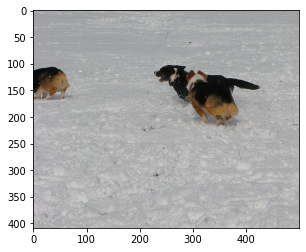

In [35]:
test_paths=read_paths('./Flicker8k_Dataset',test_ids)
dataset=Flickr8k_Images(test_paths,transform=transforms.ToTensor())
loader=DataLoader(dataset,batch_size=1)

x=next(iter(loader))
plt.imshow(x[0].permute(1,2,0))
plt.show()


In [36]:
test_features=torch.tensor([])
model_CNN.eval() 
with torch.no_grad():
    for batch_idx, (data) in enumerate(tqdm(loader)):
        
        data = data.to(device)
        output = model_CNN(data)
        test_features=torch.cat((test_features.to(device=device),output),dim=0)

100%|██████████| 5015/5015 [03:48<00:00, 21.94it/s]


In [37]:
pred_ids = model.sample(test_features)

In [38]:
def test_pred(location,vocab,ids):
    
    sampled_ids = ids[location].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<unk>':
            continue
        sampled_caption.append(word)
    sentence = ' '.join(sampled_caption)
    return sentence
    # Print out the image and the generated caption
def show_date(location,vocab,sentence):
    image=dataset[location]
    print ("Predicted Sentence: \n\n" + sentence)
    print('\nReference Captions:\n')
    for i in range(location,location+5):
        print(" ".join(test_captions[i]))

    plt.imshow(image.permute(1,2,0))
    plt.show()

Predicted Sentence: 

a person riding a bicycle on a dirt path a dirt bike up a hill and helmet

Reference Captions:

two cyclists atop a hill as seen from below 
two cyclist wearing red shirts going over a red hill
two people in red outfits riding their bicycles down a dirt road 
two people ride their bikes down a dirt road 
two people riding their bikes on a hill 


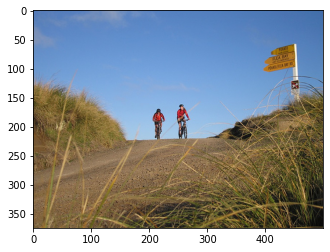

In [39]:
out=test_pred(100,vocab,pred_ids)
show_date(100,vocab,out)

Predicted Sentence: 

a dog is running through the snow a red ball and a black and white dog

Reference Captions:

one dog is standing whilst two other dogs are running in the snow 
three dogs are playing around in the snow 
three dogs chasing each other in the snow 
three dogs play in snow 
two dogs play together in the snow 


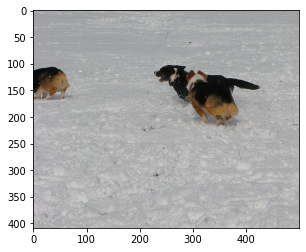

In [40]:
out=test_pred(0,vocab,pred_ids)
show_date(0,vocab,out)

Predicted Sentence: 

a man in a red shirt and jeans skateboards over a hill and

Reference Captions:

a guy on inline skates with a white hat is on a yellow rail 
a male skater is riding a yellow rail
a man rollerblades across a yellow pole at night 
an inline skater boy balances on a yellow rail 
a skater does a trick on a yellow handrail 


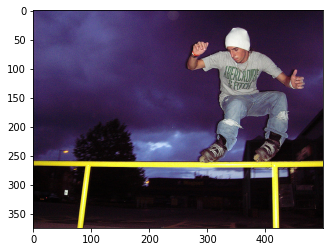

In [41]:
out=test_pred(210,vocab,pred_ids)
show_date(210,vocab,out)

Predicted Sentence: 

a man and a dog are standing on a grassy field one of them is carring a ball

Reference Captions:

a man holds a long leash with a large gray dog attached to it 
a man is holding a very long leash attached to a very large dog who is smelling the grass 
a man is walking a grey dog on the grass using a long leash 
a man walks a black dog on a very long leash 
a woman and a dog are in a field of bright green grass and brilliant blue sky 


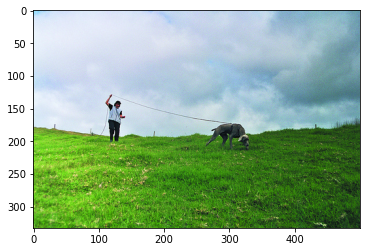

In [42]:
out=test_pred(540,vocab,pred_ids)
show_date(540,vocab,out)

Predicted Sentence: 

a boy in a blue shirt and a white shirt is standing in front of a crowd with many

Reference Captions:

a child is squirted with water while older people sit and watch 
a child surrounded by adults in lawn chairs being splashed out of a bottle of water 
a group of older women watch a little boy laugh as he gets squirted with water outside 
a young boy smiling with people looking in his direction and a bottle to his left
the family enjoys an afternoon at the park in the shade 


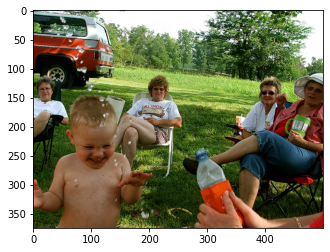

In [43]:
out=test_pred(4000,vocab,pred_ids)
show_date(4000,vocab,out)

## 2.2 Caption evaluation via text similarity 

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods: 

1. Bilingual Evaluation Understudy (BLEU), and
2. Cosine similarity

### 2.2.1 BLEU score 

One common way of comparing a generated text to a reference text is using BLEU.

> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

In [44]:
all_preds=[]
for i in range(0,len(pred_ids),5):
    all_preds.append(test_pred(i,vocab,pred_ids))
    
hypothesis=[x.split(' ') for x in all_preds]
refs=test_captions

In [45]:
scores=[]
j=0
for i in range(0,len(refs),5):
    score=nltk.translate.bleu_score.sentence_bleu([refs[i][:-1],refs[i+1][:-1],refs[i+2][:-1],refs[i+3][:-1],refs[i+4][:-1]],
                                                  hypothesis[j])
    j+=1
    scores.append(score)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [46]:
np.mean(scores)

0.4434462074784866

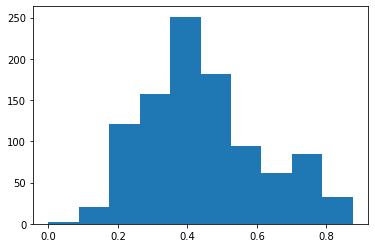

In [47]:
plt.hist(scores)
plt.show()

### 2.2.2 BLEU score examples

Finding one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [48]:
def max_min_score(score):
    
    min_value = max(score)
    min_index=score.index(min_value)
    
    max_value = min(score)
    max_index=score.index(max_value)

    print('MAX SCORE SAMPLE\n')    
    out=test_pred(max_index,vocab,pred_ids)
    show_date(max_index,vocab,out)  
    
    print('\n\n\n')
        
    print('MIN SCORE SAMPLE\n')    
    out=test_pred(min_index,vocab,pred_ids)
    show_date(min_index,vocab,out)

MAX SCORE SAMPLE

Predicted Sentence: 

a man in a blue shirt and jeans is standing on a hill and a backpack

Reference Captions:

one man is climbing a rock wall  while another man  below  holds a rope 
two men climbing a mountain
a rock climber 
there are two people rock climbing  one is on the ground while the other climbs 
two men climb a large rock 


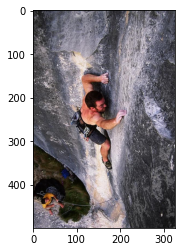





MIN SCORE SAMPLE

Predicted Sentence: 

a man wearing a white shirt and black shorts is holding a cigarette and a woman in a black

Reference Captions:

people on a cruise ship deck  and overlooking the deck 
people stand on the balcony and deck of a boat 
the people on the balcony are controlling the man in the white shorts like a puppet 
a dog s mouth opens to expose its sharp teeth 
a dog tries to bite another dog 


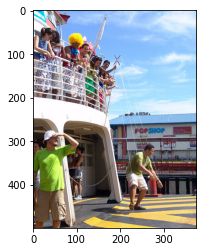

In [49]:
max_min_score(scores)

### 2.2.3 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Finding the embedding vector of each word in the caption 
* Computing the average vector for each caption 
* Computing the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Computing the average of these scores 

Calculating the cosine similarity using the model's predictions over the whole test set. 


In [50]:
from gensim.models import Word2Vec

embeeded=Word2Vec(test_captions)


In [51]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    return Counter(text)
k=0
final_cosine=[]
for i in range(0,len(refs),5):
    cosine_score=[]
    for j in range(5):

        vector1 = text_to_vector(hypothesis[k])
        vector2 = text_to_vector(refs[i+j])
        cosine = get_cosine(vector1, vector2)
        cosine_score.append(cosine)
    k+=1

    final_cosine.append(np.mean(cosine_score))
    
print("Cosine:", np.mean(final_cosine))

Cosine: 0.3821206983903797


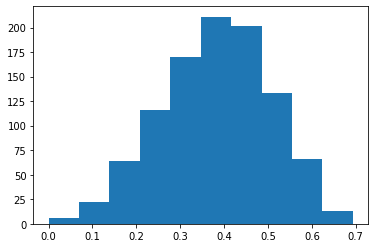

In [52]:
plt.hist(final_cosine)
plt.show()

### 2.2.4 Cosine similarity examples 

Finding one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

## 2.3 Comparing text similarity methods 

### 2.3.1 Test set distribution of scores 

Comparing the model’s performance on the test set evaluated using BLEU and cosine similarity.

To compare the average test scores, we need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [53]:
normalized_cosine = (final_cosine-min(final_cosine))/(max(final_cosine)-min(final_cosine))
# TO COMPLETE
normalized_cosine[:10]

array([0.2291412 , 0.72357565, 0.56738964, 0.6004256 , 0.33341706,
       0.48688692, 0.75758769, 0.42711107, 0.48785409, 0.42923376])

In [54]:
scores[:10]

[0.45180100180492244,
 0.30064545690526145,
 0.8132882808488929,
 0.2559142512628947,
 0.7896895367562644,
 0.7790872728179328,
 0.395671672945243,
 0.35930411196308426,
 0.37991784282579627,
 0.7259795291154771]

 ### 2.3.2 Analysis of individual examples
 
Finding and displaying one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

Predicted Sentence: 

a man in a blue shirt and jeans is standing on a hill and a backpack

Reference Captions:

one man is climbing a rock wall  while another man  below  holds a rope 
two men climbing a mountain
a rock climber 
there are two people rock climbing  one is on the ground while the other climbs 
two men climb a large rock 


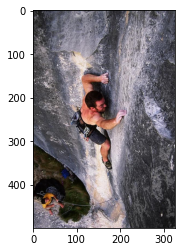

In [55]:
# this is when both scores are equal
for i in range(len(scores)):
    if scores[i] == normalized_cosine[i]:
        out=test_pred(i,vocab,pred_ids)
        show_date(i,vocab,out)
        
        

Predicted Sentence: 

a man wearing a blue shirt and blue jeans is jumping in the air on his skateboard a metal

Reference Captions:

a very hairy dog is running down a hall 
flowers are behind the fluffy dog that is coming up the step 
a brown and black dog runs through the leaves 
a brown dog is running 
a brown dog with a red collar jumping across a leafy lawn 


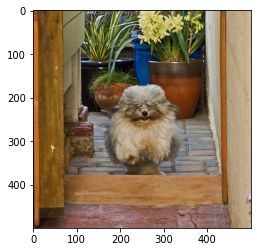

In [56]:
# when two scores are different
for i in range(len(scores)):
    if abs(scores[i] - normalized_cosine[i])>0.5:
        out=test_pred(i,vocab,pred_ids)
        show_date(i,vocab,out)
        break